# Efecto Información Bioquímica

## Vamos a comprobar si la información bioquímica tiene algún efecto en el aprendizaje. 

## Como hemos visto, las métricas sobre el test set son algo peores que las métricas de train. Vamos a mejorar el modelo añadiendo información bioquímica en la fase final de clasificación, de forma que el clasificador pueda tener información que no se puede decodificar de la secuencia de aminoácidos

In [28]:
from transformers.modeling_outputs import SequenceClassifierOutput
from typing import Optional, Tuple, Union
from MultiGPUModels import MultiGPUBertModel
import torch
import torch.nn as nn


class MultiGPUBertForPeptideClassification(BertForSequenceClassification):
    def __init__(self, bert_model_for_sequence_classification, biochem_cols):
        super(MultiGPUBertForPeptideClassification, self).__init__(bert_model_for_sequence_classification.config)
                
        self.num_labels = bert_model_for_sequence_classification.num_labels
        self.config = bert_model_for_sequence_classification.config
        self.biochem_cols = biochem_cols

      # self.bert = BertModel(config)
        self.bert = MultiGPUBertModel(bert_model_for_sequence_classification.bert)

        self.dropout = nn.Dropout(0.01).to("cuda:0")
        self.classifier = nn.Linear(self.config.hidden_size + len(self.biochem_cols), self.num_labels).to("cuda:0")
        
    def forward(
            self,
            dataloader_item = None,
            input_ids: Optional[torch.Tensor] = None,
            attention_mask: Optional[torch.Tensor] = None,
            biochem_info: Optional[torch.Tensor] = None,
        ) -> SequenceClassifierOutput:
            r"""
                Si se pasa un elemento de un dataloader, se sacan todos los parametros de ahí
                Si no, se usan el resto
            """
            if dataloader_item != None:
                input_ids = dataloader_item['input_ids'].to("cuda:0")
                attention_mask = dataloader_item['attention_mask'].to("cuda:0")
                biochem_info = dataloader_item['biochem_info'].to('cuda:0')

    
            # Paso los inputs por el bert para que me los devuelva codificados
            outputs = self.bert(
                input_ids,
                attention_mask=attention_mask,
            )
                
            # Aqui los recojo
            pooled_output = outputs[1]
    
            # Aplico dropout
            dropout_output = self.dropout(pooled_output)
            
            # Concateno la información bioquimica
            output_with_biochem = torch.cat([dropout_output, biochem_info], dim = 1)
            
            # Clasifico 
            logits = self.classifier(output_with_biochem)
            
            return SequenceClassifierOutput(
                loss=None,
                logits=logits,
                hidden_states=pooled_output,
                attentions=outputs.attentions,
            )        

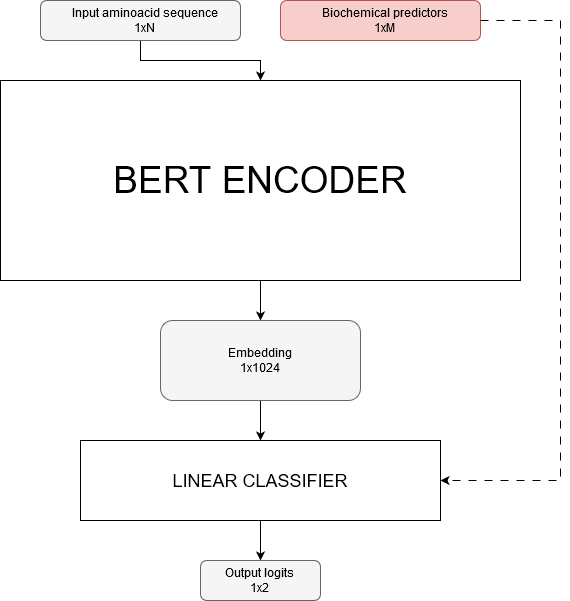

In [1]:
from IPython.display import Image
Image(filename='BioChemModel.png') 

## Para este nuevo modelo habrá que crear estructuras de datos capaces de aportar esa información bioquímica

In [1]:
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
import torch

class AMP_BioChemDataset(Dataset):
    """
        Esta clase permite formar un Dataset legible para los modelos de PyTorch
        Implementa los métodos necesarios para entrenar un BERT
    """
    def __init__(self, df, biochem_cols, tokenizer_name='Rostlab/prot_bert_bfd', max_len=200):
        super(Dataset, AMP_BioChemDataset).__init__(self)
        self.tokenizer = BertTokenizer.from_pretrained(tokenizer_name, do_lower_case=False)
        self.df = df
        self.max_len = max_len
        self.seqs = list(df['aa_seq'])
        self.biochem_cols = biochem_cols
        if "molecular_mass" in self.biochem_cols:
            self.df.loc[:,'molecular_mass'] = self.df.loc[:,'molecular_mass'] / 1e4
        if "aliphatic"

        self.labels = list(df['AMP'].astype(int))        
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        seq = " ".join("".join(self.seqs[idx].split()))
        seq_enc = self.tokenizer(
            seq, 
            truncation=True, 
            padding='max_length', 
            max_length=self.max_len,
            return_tensors = 'pt',
            return_attention_mask=True
        )
        seq_label = self.labels[idx]
        seq_biochem = self.df.iloc[idx].loc[self.biochem_cols]
        seq_biochem.transpose()
                
        return {
            'idx': idx,
            'input_ids': seq_enc['input_ids'].flatten(),
            'attention_mask' : seq_enc['attention_mask'].flatten(),
            'labels' : torch.tensor(seq_label, dtype=torch.long),
            'biochem_info': torch.tensor(seq_biochem, dtype=torch.float32),
        }
    

class AMP_BioChemDataLoader(DataLoader):
    """
        Es una estructura de datos iterable con mini-batches de datos
    
        dataframe   --  Un dataframe de Pandas con los datos, con columnas 'aa_seq' y 'AMP'
        batch_size  --  El tamaño de mini-batch con el que vas a entrenar el modelo   
    """
    def __init__(self, dataframe, biochem_cols, batch_size):
        DataLoader.__init__(
            self,
            AMP_BioChemDataset(dataframe, biochem_cols),
            batch_size = batch_size,
            num_workers = 2,
            shuffle = True
        )

## El algoritmo de Grid Search, por tanto, debe ser modificado también

In [3]:
from itertools import product
from sklearn.model_selection import KFold
from copy import deepcopy
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from transformers import get_linear_schedule_with_warmup
import pandas as pd
from time import process_time_ns
from pipeline_tools import compute_metrics

biochem_cols = [
    "molecular_mass",
    "hydrophobic_freq",
    "hydrophilic_freq",
    "basic_freq",
    "acid_freq",
    "charge",
    "aliphatic_index",
    "average_hydrophobicity",
    "isoelectric_point"
]

def grid_search_train_val(model, train_dataframe, val_dataframe, grid, loss_fn = CrossEntropyLoss(), verbose = False):
                
    param_combinations = product(
        grid["epochs"],
        grid["batch_size"],
        grid["learning_rate"],
        grid["betas"],
        grid["epsilon"],
        grid["weight_decay"],
        grid["warmup_steps"]
    )
    
    all_combs = []
    all_metrics = []
    all_losses = []
        
    # Calculamos todas las combinaciones con el grid de hiperparametros
    num_combinations = 1
    for key in grid.keys():
        num_combinations *= len(grid[key])
    
    print()
    print(f"Number of combinations: {num_combinations}")

    for combination in param_combinations:
        
        # En cada combinacion entrenamos y testeamos
        epochs, batch_size, learning_rate, betas, epsilon, weight_decay, warmup_steps = combination
        
        # Los datasets seran los mismos en cada configuracion
        train_data_loader = AMP_BioChemDataLoader(train_dataframe, biochem_cols, batch_size = batch_size)
        val_data_loader = AMP_BioChemDataLoader(val_dataframe, biochem_cols, batch_size = batch_size)
        
        print()
        print("Next combination:")
        print(f"epochs: {epochs}")
        print(f"batch_size: {batch_size}")
        print(f"learning_rate: {learning_rate}")
        print(f"betas: {betas}")
        print(f"epsilon: {epsilon}")
        print(f"weight_decay: {weight_decay}")
        print(f"warmup_steps: {warmup_steps}")
        
        # Copiamos el modelo
        model_copy = deepcopy(model)
        
        # Preparamos el optimizador y el scheduler
        optimizer = AdamW(
            model_copy.parameters(), 
            lr = learning_rate,
            betas = betas,
            eps = epsilon,
            weight_decay = weight_decay
        )
        
        total_steps = len(train_data_loader) * epochs

        scheduler = get_linear_schedule_with_warmup(optimizer, 
                                           num_warmup_steps = warmup_steps, 
                                           num_training_steps = total_steps)
        # Entrenamos
        train_start = process_time_ns()
        for epoch in range(epochs):
            _, _, losses = train_model(model_copy, train_data_loader, loss_fn, optimizer, scheduler, verbose)
        train_end = process_time_ns()
        
        # Medimos
        eval_start = process_time_ns()
        labels, predictions = eval_model(model_copy, val_data_loader, loss_fn, verbose)
        eval_end = process_time_ns()

        metrics = compute_metrics(labels, predictions)
        metrics["train_time_secs"] = (train_end - train_start) // (10 ** 9)
        metrics["eval_time_secs"] = (eval_end - eval_start) // (10 ** 9)
        print(metrics)
        
        # Guardamos las medidas
        all_combs.append(combination)
        all_metrics.append(metrics)
        all_losses.append(losses)
                    
        del model_copy
        
    df_combs = pd.DataFrame(all_combs, index = range(num_combinations), columns=['epochs', 'batch_size', 'learning_rate', 'betas', 'epsilon', 'weight_decay', 'warmup_steps'])
    df_metrics = pd.concat(all_metrics)
    df_metrics.index = range(num_combinations)
    df_results = pd.concat([df_combs, df_metrics], axis=1)
    
    df_losses = pd.DataFrame(all_losses, index = range(num_combinations))
    
    return df_results, df_losses

## Ahora vamos a realizar un grid search para encontrar la mejor configuración del número de épocas sobre el modelo anterior, dado que es el único hiperparámetro que deberíamos modificar para evitar un overfitting. Probaremos hasta 15 épocas

## Nuestro conjunto de train ahora se usará por completo, y para la validación se usará un subconjunto del conjunto de test anterior. Se mantiene la proporción 52%-48%

In [3]:
import pandas as pd

SEED = 0
FRAC_VAL = 0.2

train_df = pd.read_csv('./datasets/all_veltri_2.csv', index_col = 0).sample(frac=1, random_state=SEED)
df_pos = pd.read_csv('./datasets/veltri_dramp_cdhit_90_2.csv', index_col = 0)
df_neg = pd.read_csv('./datasets/non_amp_ampep_cdhit90_2.csv', index_col = 0)

val_df_pos = df_pos.sample(frac=FRAC_VAL, random_state=SEED)
val_df_neg = df_neg.sample(frac=FRAC_VAL, random_state=SEED)
test_df_pos = df_pos.drop(val_df_pos.index)
test_df_neg = df_neg.drop(val_df_neg.index)

val_df = pd.concat([val_df_pos, val_df_neg]).sample(frac=1, random_state=SEED)
test_df = pd.concat([test_df_pos, test_df_neg]).sample(frac=1, random_state=SEED)

print(f"Validation dataframe: {len(val_df_pos)} positives, {len(val_df_neg)} negatives ({len(val_df_pos)/len(val_df)}%)")
print(f"Test dataframe: {len(test_df_pos)} positives, {len(test_df_neg)} negatives ({len(test_df_pos)/len(test_df)}%)")

Validation dataframe: 413 positives, 382 negatives (0.519496855345912%)
Test dataframe: 1652 positives, 1526 negatives (0.5198237885462555%)


In [5]:
from transformers import BertForSequenceClassification
from MultiGPUModels import MultiGPUBertForPeptideClassification

bert_model = BertForSequenceClassification.from_pretrained('Rostlab/prot_bert_bfd')   
multi_gpu_bert = MultiGPUBertForPeptideClassification(bert_model, biochem_cols)

grid = {
    "epochs": [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],
    "learning_rate": [5e-6],
    "weight_decay": [0.01],
    "batch_size": [8],
    "warmup_steps": [0],
    "betas": [(0.9, 0.999)],
    "epsilon": [1e-8],
}

# Busco en un grid
grid_search_results, grid_search_losses = grid_search_train_val(multi_gpu_bert, train_df, val_df, grid)

print()
print("Resultados:")
print(grid_search_results)

grid_search_results.to_csv('biochem_results/grid_search_results.csv', index=False)
grid_search_losses.to_csv('biochem_results/grid_search_losses.csv', index=False)  

Some weights of the model checkpoint at Rostlab/prot_bert_bfd were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init


Number of combinations: 15

Next combination:
epochs: 1
batch_size: 8
learning_rate: 5e-06
betas: (0.9, 0.999)
epsilon: 1e-08
weight_decay: 0.01
warmup_steps: 0
   accuracy        f1  precision    recall  specificity     auroc      aupr  \
0  0.774843  0.791132   0.763514  0.820823     0.725131  0.772977  0.838709   

          confusion_matrix  train_time_secs  eval_time_secs  
0  [[277, 105], [74, 339]]              326              23  

Next combination:
epochs: 2
batch_size: 8
learning_rate: 5e-06
betas: (0.9, 0.999)
epsilon: 1e-08
weight_decay: 0.01
warmup_steps: 0
   accuracy        f1  precision    recall  specificity    auroc      aupr  \
0  0.769811  0.786962   0.757848  0.818402     0.717277  0.76784  0.835295   

          confusion_matrix  train_time_secs  eval_time_secs  
0  [[274, 108], [75, 338]]              653              23  

Next combination:
epochs: 3
batch_size: 8
learning_rate: 5e-06
betas: (0.9, 0.999)
epsilon: 1e-08
weight_decay: 0.01
warmup_steps: 0
   acc

## Las métricas obtenidas se muestran ahora en las siguientes gráficas. Se ha obtenido que, aunque el *recall* aumenta con el número de épocas, el resto de métricas obtienen su mejor marca con la primera época. Dado lo reducido que es el dataset, parece que usar más de una época induce a un sobreajustamiento

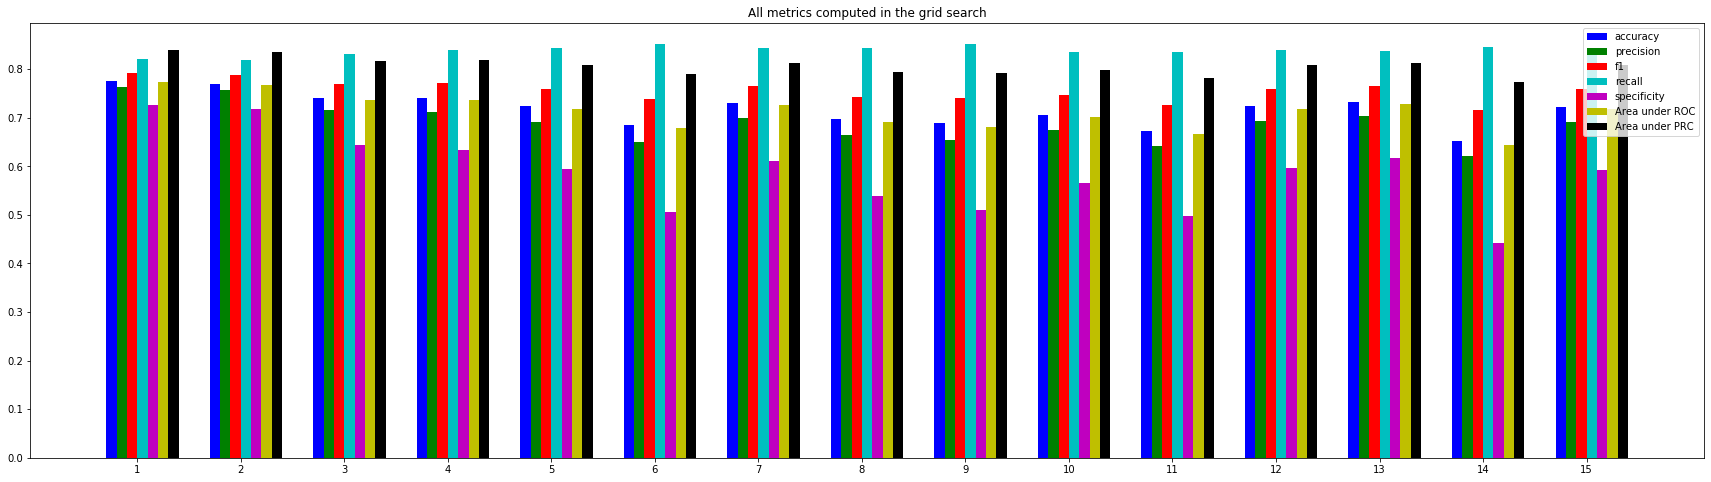

In [14]:
import matplotlib.pyplot as plt
import numpy as np

grid_search_results = pd.read_csv('biochem_results/grid_search_results.csv')

index = np.arange(len(grid_search_results["learning_rate"]))
tags = [f"{grid_search_results['epochs'][i]}" for i in index]

w = 0.1

plt.figure(figsize=(30,8))

plt.bar(index - 3*w, grid_search_results["accuracy"], color="b", label="accuracy", width=w)
plt.bar(index - 2*w, grid_search_results["precision"],  color="g", label="precision", width=w)
plt.bar(index - 1*w, grid_search_results["f1"], color="r", label="f1", width=w)
plt.bar(index + 0*w, grid_search_results["recall"], color="c", label="recall", width=w)
plt.bar(index + 1*w, grid_search_results["specificity"], color="m", label="specificity", width=w)
plt.bar(index + 2*w, grid_search_results["auroc"], color="y", label="Area under ROC", width=w)
plt.bar(index + 3*w, grid_search_results["aupr"], color="k", label="Area under PRC", width=w)

plt.xticks(index - w/2, tags)
plt.legend()
plt.title("All metrics computed in the grid search")
plt.show()

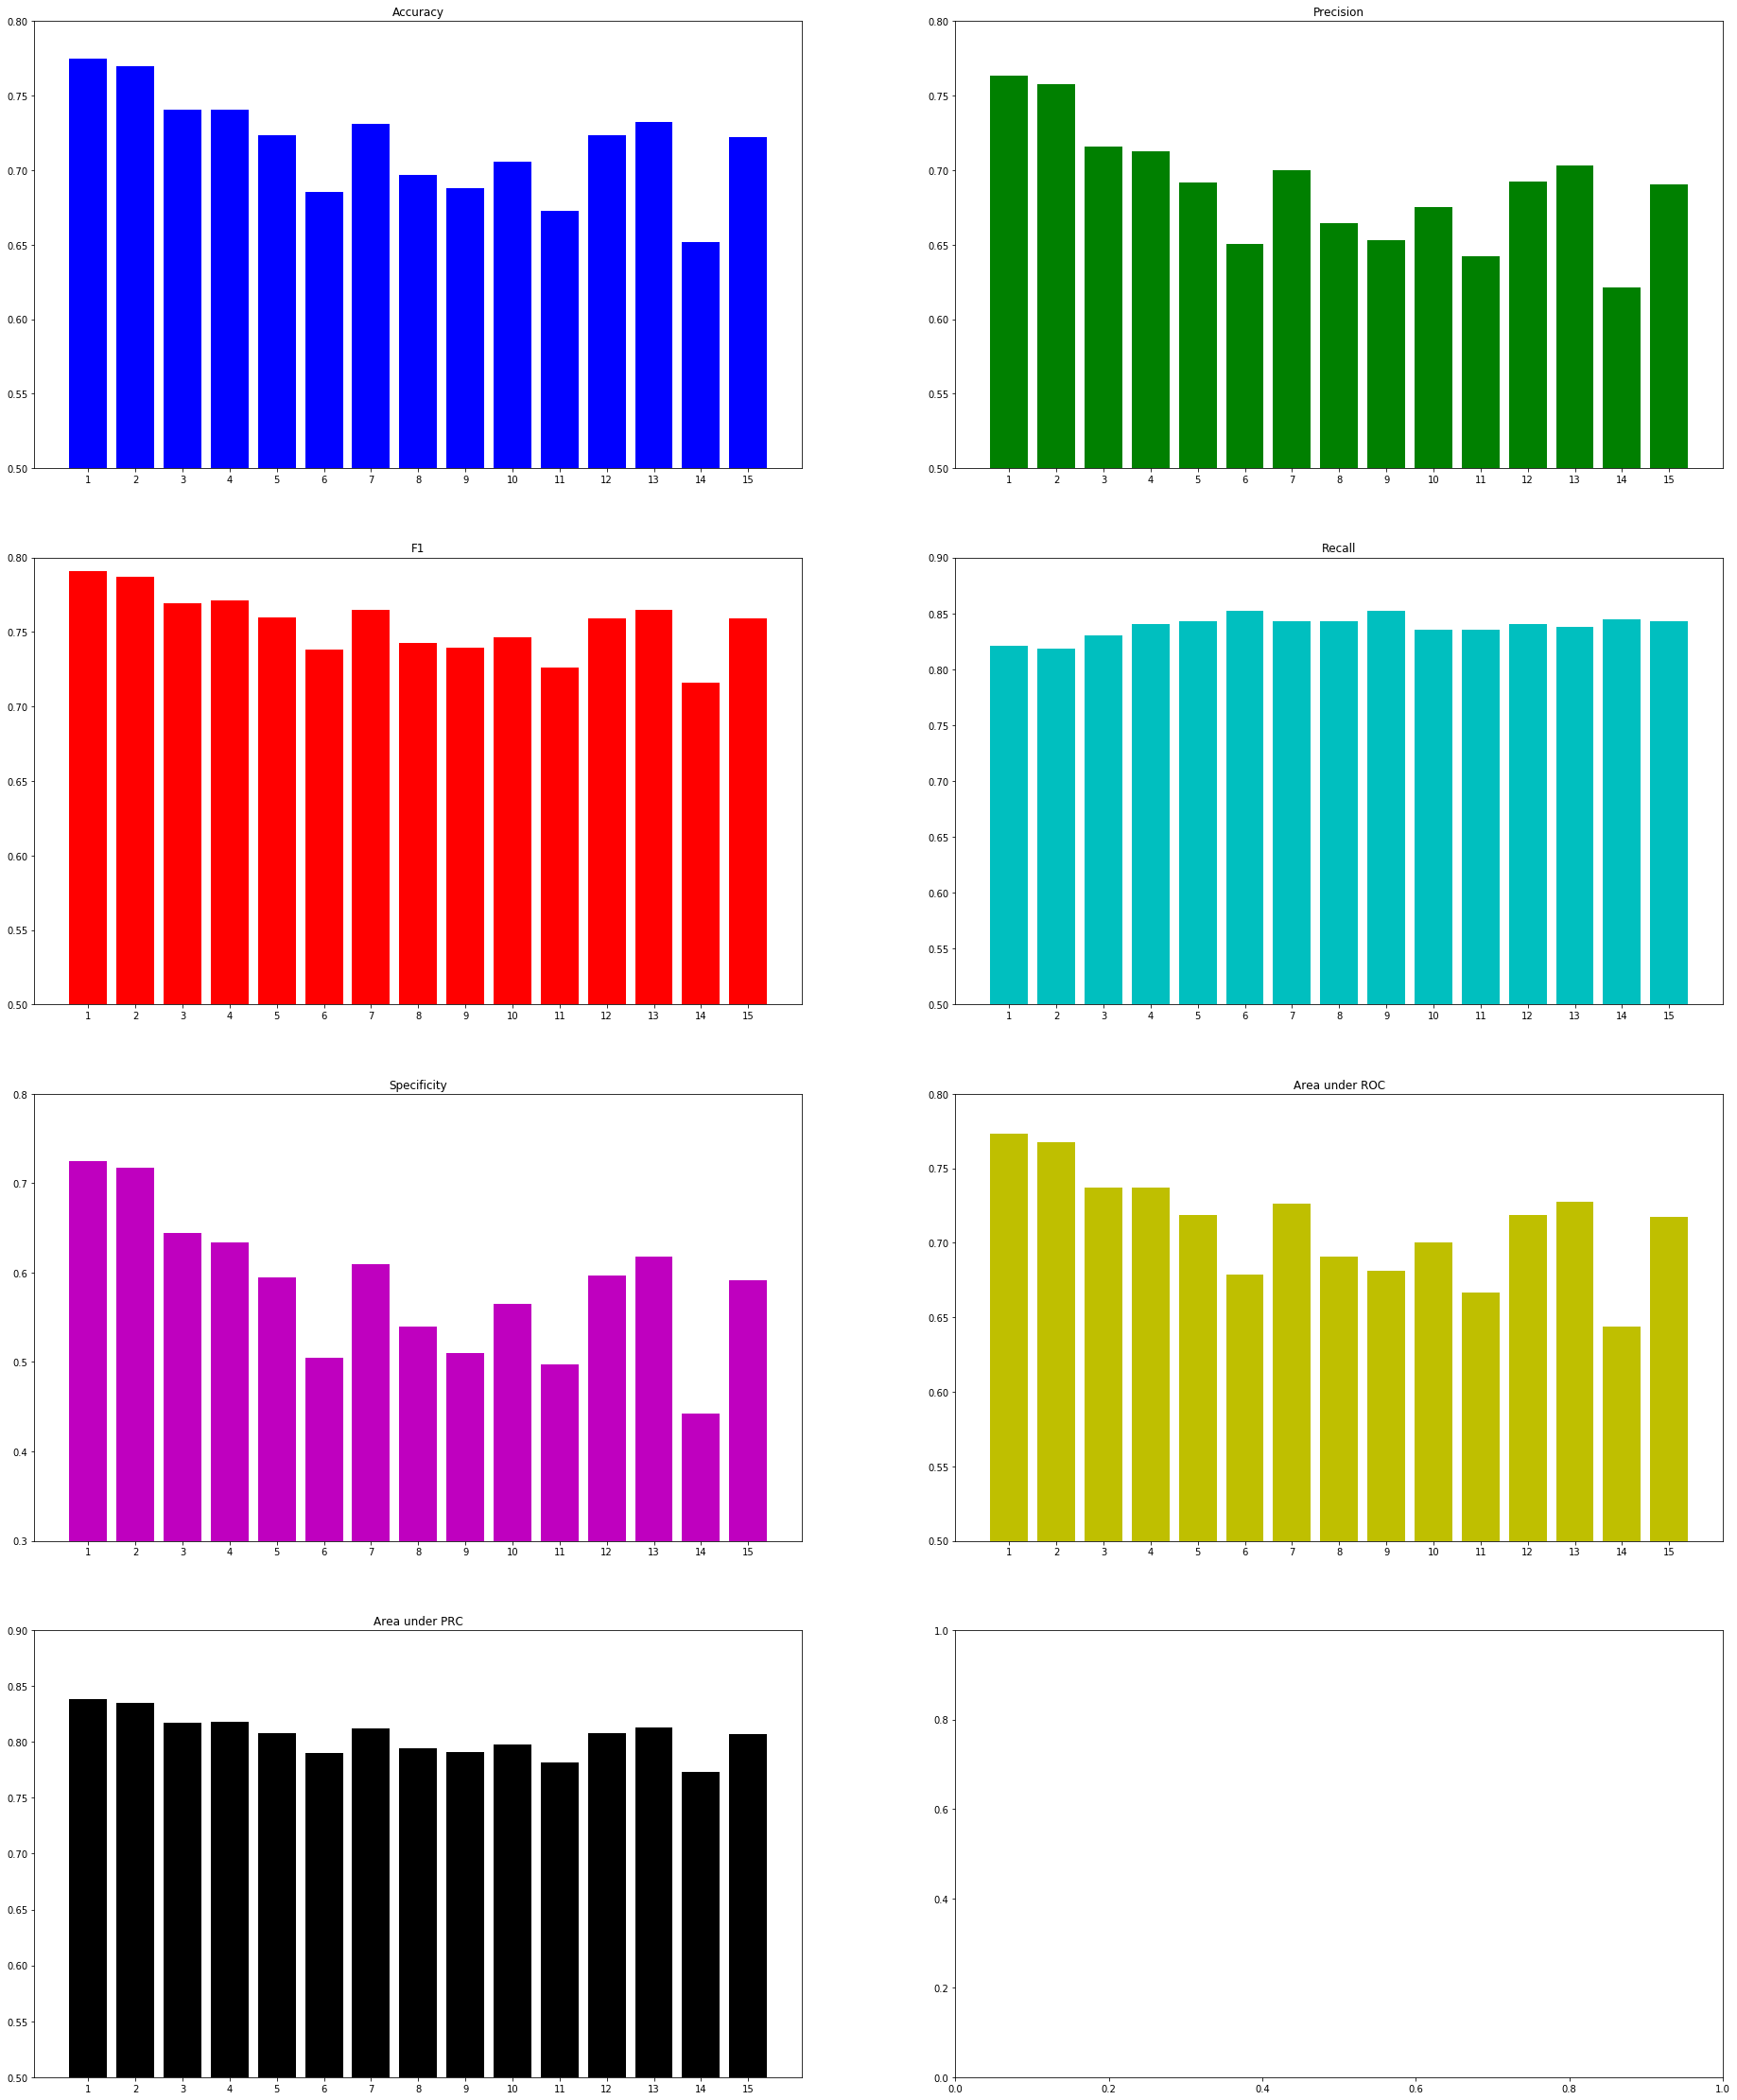

In [34]:
fig, axs = plt.subplots(4,2, figsize=(32, 40))

w = 0.8

axs[0][0].bar(index, grid_search_results["accuracy"], color='b', width=w)
axs[0][0].set_title("Accuracy")
axs[0][0].set_xticks(index)
axs[0][0].set_xticklabels(tags)
axs[0][0].set_ylim(0.5,0.8)

axs[0][1].bar(index, grid_search_results["precision"], color='g', width=w)
axs[0][1].set_title("Precision")
axs[0][1].set_xticks(index)
axs[0][1].set_xticklabels(tags)
axs[0][1].set_ylim(0.5,0.8)

axs[1][0].bar(index, grid_search_results["f1"], color='r', width=w)
axs[1][0].set_title("F1")
axs[1][0].set_xticks(index)
axs[1][0].set_xticklabels(tags)
axs[1][0].set_ylim(0.5,0.8)

axs[1][1].bar(index, grid_search_results["recall"], color='c', width=w)
axs[1][1].set_title("Recall")
axs[1][1].set_xticks(index)
axs[1][1].set_xticklabels(tags)
axs[1][1].set_ylim(0.5,0.9)

axs[2][0].bar(index, grid_search_results["specificity"], color='m', width=w)
axs[2][0].set_title("Specificity")
axs[2][0].set_xticks(index)
axs[2][0].set_xticklabels(tags)
axs[2][0].set_ylim(0.3,0.8)

axs[2][1].bar(index, grid_search_results["auroc"], color='y', width=w)
axs[2][1].set_title("Area under ROC")
axs[2][1].set_xticks(index)
axs[2][1].set_xticklabels(tags)
axs[2][1].set_ylim(0.5,0.8)

axs[3][0].bar(index, grid_search_results["aupr"], color='k', width=w)
axs[3][0].set_title("Area under PRC")
axs[3][0].set_xticks(index)
axs[3][0].set_xticklabels(tags)
axs[3][0].set_ylim(0.5,0.9)


plt.show()

## Finalmente entrenamos y testeamos el nuevo modelo contra los datos de test, y comprobamos el rendimiento obtenido respecto al modelo que entrenamos inicialmente y a las métricas de test de referencia

In [4]:
from pipeline_tools import AMP_DataLoader, train_model, eval_model, compute_metrics
from torch.optim import AdamW
from transformers import BertForSequenceClassification, get_linear_schedule_with_warmup
from MultiGPUModels import MultiGPUBertForPeptideClassification
from torch.nn import CrossEntropyLoss

BATCH_SIZE = 8
LEARNING_RATE = 5e-6
WEIGHT_DECAY = 0.01
EPOCHS = 1
            
biochem_cols = [
    "molecular_mass",
    "hydrophobic_freq",
    "hydrophilic_freq",
    "basic_freq",
    "acid_freq",
    "charge",
    "aliphatic_index",
    "average_hydrophobicity",
    "isoelectric_point"
]

train_dataloader = AMP_BioChemDataLoader(train_df, biochem_cols, batch_size = BATCH_SIZE)            
test_dataloader = AMP_BioChemDataLoader(test_df, biochem_cols, batch_size = BATCH_SIZE)            

# Copiar el modelo para entrenarlo
bert_model = BertForSequenceClassification.from_pretrained('Rostlab/prot_bert_bfd')   
multi_gpu_bert = MultiGPUBertForPeptideClassification(bert_model, biochem_cols)
            
# Entrenar el modelo con esta configuracion
optimizer = AdamW(
    multi_gpu_bert.parameters(), 
    lr = LEARNING_RATE, 
    weight_decay = WEIGHT_DECAY)
            
total_steps = len(train_dataloader) * EPOCHS
            
scheduler = get_linear_schedule_with_warmup(optimizer, 
    num_warmup_steps = 0, 
    num_training_steps = total_steps)

for i in range(EPOCHS):
    labels, predicted, _ = train_model(multi_gpu_bert, train_dataloader, CrossEntropyLoss(), optimizer, scheduler, True)

# Obtener las métricas de entrenamiento
train_metrics = compute_metrics(labels, predicted)
            
print(f"Metrics for train set: ")
print(train_metrics)

# Obtener las métricas de validacion
test_labels, test_preds = eval_model(multi_gpu_bert, test_dataloader, CrossEntropyLoss(), True)
test_metrics = compute_metrics(test_labels, test_preds)
            
print(f"Metrics for test set: ")
print(test_metrics)

test_metrics.to_csv('./biochem_results/test_metrics_with_biochem_1ep.csv')

Some weights of the model checkpoint at Rostlab/prot_bert_bfd were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

Step 10/445: Loss (avg) 0.4915732778215458, Step Time 714 ms, ETA 5:10
Step 20/445: Loss (avg) 0.7196020602922891, Step Time 715 ms, ETA 5:3
Step 30/445: Loss (avg) 0.7644106610414275, Step Time 715 ms, ETA 4:56
Step 40/445: Loss (avg) 0.7556779090789342, Step Time 717 ms, ETA 4:50
Step 50/445: Loss (avg) 0.7592797060430243, Step Time 718 ms, ETA 4:43
Step 60/445: Loss (avg) 0.712951204312401, Step Time 720 ms, ETA 4:37
Step 70/445: Loss (avg) 0.6742086486812526, Step Time 724 ms, ETA 4:31
Step 80/445: Loss (avg) 0.6070117787309652, Step Time 721 ms, ETA 4:23
Step 90/445: Loss (avg) 0.5936003792012603, Step Time 715 ms, ETA 4:13
Step 100/445: Loss (avg) 0.5681672756742372, Step Time 728 ms, ETA 4:11
Step 110/445: Loss (avg) 0.5129649575356622, Step Time 724 ms, ETA 4:2
Step 120/445: Loss (avg) 0.5471392030712878, Step Time 724 ms, ETA 3:55
Step 130/445: Loss (avg) 0.5092423216829542, Step Time 726 ms, ETA 3:48
Step 140/445: Loss (avg) 0.44956420050326457, Step Time 724 ms, ETA 3:40
Ste

/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Step 10/398: Loss (avg) 0.38903074733139104, Step Time 237 ms, ETA 1:31
Step 20/398: Loss (avg) 0.43076837136765617, Step Time 236 ms, ETA 1:29
Step 30/398: Loss (avg) 0.5986309531566439, Step Time 236 ms, ETA 1:26
Step 40/398: Loss (avg) 0.5739778819603186, Step Time 234 ms, ETA 1:23
Step 50/398: Loss (avg) 0.460983278216322, Step Time 235 ms, ETA 1:21
Step 60/398: Loss (avg) 0.546885057897403, Step Time 235 ms, ETA 1:19
Step 70/398: Loss (avg) 0.4574011305706991, Step Time 237 ms, ETA 1:17
Step 80/398: Loss (avg) 0.5190561254717224, Step Time 236 ms, ETA 1:15
Step 90/398: Loss (avg) 0.5088383977651869, Step Time 235 ms, ETA 1:12
Step 100/398: Loss (avg) 0.6273868150359221, Step Time 235 ms, ETA 1:10
Step 110/398: Loss (avg) 0.565727269911976, Step Time 235 ms, ETA 1:7
Step 120/398: Loss (avg) 0.6884936076532041, Step Time 236 ms, ETA 1:5
Step 130/398: Loss (avg) 0.5371688726131812, Step Time 235 ms, ETA 1:2
Step 140/398: Loss (avg) 0.4871444286687004, Step Time 235 ms, ETA 1:0
Step 1

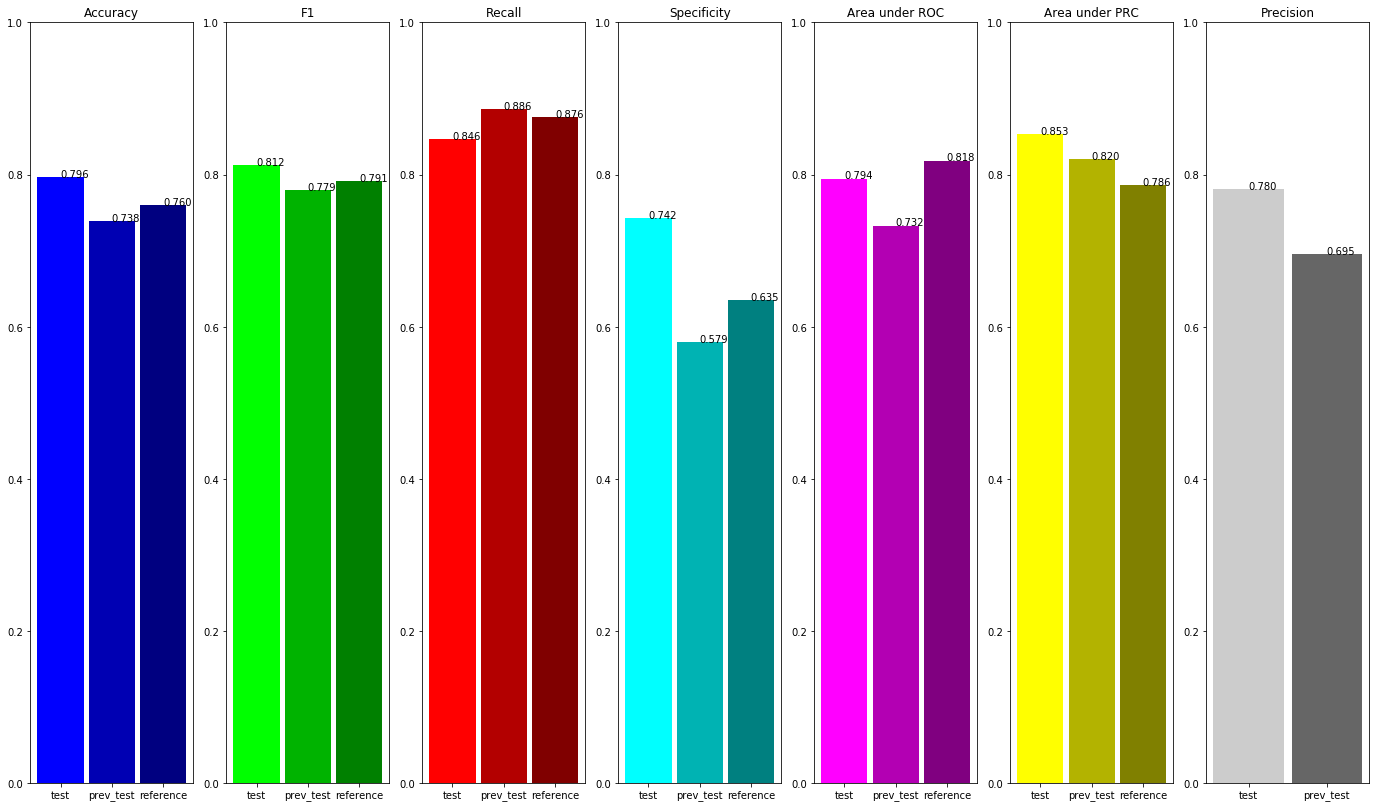

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

ref_test_metrics = pd.read_csv('./results/ref_metrics_test.csv')
prev_test_metrics = pd.read_csv('./results/test_metrics.csv')
test_metrics = pd.read_csv('./biochem_results/test_metrics_with_biochem_1ep.csv')

fig, axs = plt.subplots(1, 7, figsize=(24, 14))

w = 0.9

axs[0].bar("test", test_metrics["accuracy"], color=(0.0, 0.0, 1.0, 1.0), width=w)
axs[0].text("test", test_metrics["accuracy"], f'{test_metrics["accuracy"][0]}'[0:5])
axs[0].bar("prev_test", prev_test_metrics["accuracy"], color=(0.0, 0.0, 0.7, 1.0), width=w)
axs[0].text("prev_test", prev_test_metrics["accuracy"], f'{prev_test_metrics["accuracy"][0]}'[0:5])
axs[0].bar("reference", ref_test_metrics["accuracy"], color=(0.0, 0.0, 0.5, 1.0), width=w)
axs[0].text("reference", ref_test_metrics["accuracy"], f'{ref_test_metrics["accuracy"][0]}'[0:5])
axs[0].set_ylim(0.0, 1.0)
axs[0].set_title("Accuracy")

axs[1].bar("test", test_metrics["f1"], color=(0.0, 1.0, 0.0, 1.0), width=w)
axs[1].text("test", test_metrics["f1"], f'{test_metrics["f1"][0]}'[0:5])
axs[1].bar("prev_test", prev_test_metrics["f1"], color=(0.0, 0.7, 0.0, 1.0), width=w)
axs[1].text("prev_test", prev_test_metrics["f1"], f'{prev_test_metrics["f1"][0]}'[0:5])
axs[1].bar("reference", ref_test_metrics["f1"], color=(0.0, 0.5, 0.0, 1.0), width=w)
axs[1].text("reference", ref_test_metrics["f1"], f'{ref_test_metrics["f1"][0]}'[0:5])
axs[1].set_ylim(0.0, 1.0)
axs[1].set_title("F1")

axs[2].bar("test", test_metrics["recall"], color=(1.0, 0.0, 0.0, 1.0), width=w)
axs[2].text("test", test_metrics["recall"], f'{test_metrics["recall"][0]}'[0:5])
axs[2].bar("prev_test", prev_test_metrics["recall"], color=(0.7, 0.0, 0.0, 1.0), width=w)
axs[2].text("prev_test", prev_test_metrics["recall"], f'{prev_test_metrics["recall"][0]}'[0:5])
axs[2].bar("reference", ref_test_metrics["recall"], color=(0.5, 0.0, 0.0, 1.0), width=w)
axs[2].text("reference", ref_test_metrics["recall"], f'{ref_test_metrics["recall"][0]}'[0:5])
axs[2].set_ylim(0.0, 1.0)
axs[2].set_title("Recall")

axs[3].bar("test", test_metrics["specificity"], color=(0.0, 1.0, 1.0, 1.0), width=w)
axs[3].text("test", test_metrics["specificity"], f'{test_metrics["specificity"][0]}'[0:5])
axs[3].bar("prev_test", prev_test_metrics["specificity"], color=(0.0, 0.7, 0.7, 1.0), width=w)
axs[3].text("prev_test", prev_test_metrics["specificity"], f'{prev_test_metrics["specificity"][0]}'[0:5])
axs[3].bar("reference", ref_test_metrics["specificity"], color=(0.0, 0.5, 0.5, 1.0), width=w)
axs[3].text("reference", ref_test_metrics["specificity"], f'{ref_test_metrics["specificity"][0]}'[0:5])
axs[3].set_ylim(0.0, 1.0)
axs[3].set_title("Specificity")

axs[4].bar("test", test_metrics["auroc"], color=(1.0, 0.0, 1.0, 1.0), width=w)
axs[4].text("test", test_metrics["auroc"], f'{test_metrics["auroc"][0]}'[0:5])
axs[4].bar("prev_test", prev_test_metrics["auroc"], color=(0.7, 0.0, 0.7, 1.0), width=w)
axs[4].text("prev_test", prev_test_metrics["auroc"], f'{prev_test_metrics["auroc"][0]}'[0:5])
axs[4].bar("reference", ref_test_metrics["auroc"], color=(0.5, 0.0, 0.5, 1.0), width=w)
axs[4].text("reference", ref_test_metrics["auroc"], f'{ref_test_metrics["auroc"][0]}'[0:5])
axs[4].set_ylim(0.0, 1.0)
axs[4].set_title("Area under ROC")

axs[5].bar("test", test_metrics["aupr"], color=(1.0, 1.0, 0.0, 1.0), width=w)
axs[5].text("test", test_metrics["aupr"], f'{test_metrics["aupr"][0]}'[0:5])
axs[5].bar("prev_test", prev_test_metrics["aupr"], color=(0.7, 0.7, 0.0, 1.0), width=w)
axs[5].text("prev_test", prev_test_metrics["aupr"], f'{prev_test_metrics["aupr"][0]}'[0:5])
axs[5].bar("reference", ref_test_metrics["aupr"], color=(0.5, 0.5, 0.0, 1.0), width=w)
axs[5].text("reference", ref_test_metrics["aupr"], f'{ref_test_metrics["aupr"][0]}'[0:5])
axs[5].set_ylim(0.0, 1.0)
axs[5].set_title("Area under PRC")
            
axs[6].bar("test", test_metrics["precision"], color=(0.8, 0.8, 0.8, 1.0), width=w)
axs[6].text("test", test_metrics["precision"], f'{test_metrics["precision"][0]}'[0:5])
axs[6].bar("prev_test", prev_test_metrics["precision"], color=(0.4, 0.4, 0.4, 1.0), width=w)
axs[6].text("prev_test", prev_test_metrics["precision"], f'{prev_test_metrics["precision"][0]}'[0:5])
axs[6].set_ylim(0.0, 1.0)
axs[6].set_title("Precision")


plt.show()